In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/gesture_data.csv


In [2]:
import ast

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Custom converters for array columns
array_converters = {'x': str_to_list, 'y': str_to_list, 'z': str_to_list}

# Read training data
training_data = pd.read_csv("./data/gesture_data.csv", 
                            converters=array_converters)

# Verify the changes
print("Training data 'x' column first row:")
print(training_data.loc[0, 'x'])
print("\nType of 'x' column first row:")
print(type(training_data.loc[0, 'x']))

Training data 'x' column first row:
[-1.25576014503751, -1.370739782544951, -1.9839655997993495, -1.3324131533336467, 0.2006510146126411, 0.9288567195009527, 0.4306107898804676, -0.02930851052871322, -0.3742481734304529, 0.31563090224655427, 1.925348328615451, 1.5804089158401833, 0.4306107898804676, 0.12399775619003224, 0.23897764382394554, -0.02930851052871322, 0.2006510146126411]

Type of 'x' column first row:
<class 'list'>


In [3]:
# checking how many data points per axes
mydict = {'x': [9999,0],
          'y': [9999,0],
          'z': [9999,0]}
for i in range(len(training_data)):
    for axes, hidden in mydict.items():
        if len(training_data.loc[i, axes]) < hidden[0]:
            mydict[axes][0] = len(training_data.loc[i, axes])
        if len(training_data.loc[i, axes]) > hidden[1]:
            mydict[axes][1] = len(training_data.loc[i, axes])

print(mydict)

{'x': [10, 51], 'y': [10, 51], 'z': [10, 51]}


In [4]:
print(training_data.head())

   id  user  gesture                                                  x  \
0   0     3       16  [-1.25576014503751, -1.370739782544951, -1.983...   
1   1     0       16  [-1.448612587493181, -1.54418083750065, -2.149...   
2   2     5        2  [1.371997640260515, 1.4641467904789716, 1.4027...   
3   3     4        8  [1.2042132629209805, 1.3117093394113715, 1.365...   
4   4     5        6  [0.2735127432113492, 0.30908169307960875, 0.16...   

                                                   y  \
0  [0.5405893101919109, 0.6131419581073716, -0.11...   
1  [0.5531080695207085, 0.6374051435375361, 0.272...   
2  [-1.8916694746227074, -1.808671134024168, -1.6...   
3  [-1.0692992132913253, -1.1232782922952929, -0....   
4  [0.13146940063485005, 0.16520937818051507, 0.1...   

                                                   z  
0  [-0.11737058698735427, 0.08215949770223907, 0....  
1  [-0.8150173543894822, -0.8777110334773569, -0....  
2  [0.8736550920453047, 0.8736550920453047, 0.8

In [5]:
# Function to pad or truncate the array
def pad_or_truncate(array, target_length=40):
    if len(array) > target_length:
        return array[:target_length]
    elif len(array) < target_length:
        return array + [0] * (target_length - len(array))
    else:
        return array

for col in ["x","y","z"]:
    training_data[col] = training_data[col].apply(pad_or_truncate)

from sklearn.model_selection import train_test_split

# Splitting the data into 50% Train, 25% Test, and 25% hiddenidation
train_data, temp_data = train_test_split(training_data, test_size=0.5, random_state=42)
test_data, hidden_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [6]:
import random
from scipy.interpolate import CubicSpline
# Function for data augmentation using CubicSpline
def time_warping(time_series, num_operations, warp_factor):
    """
    Applying time warping to a time series with balanced insertions and deletions.

    :param time_series: Time series, numpy array.
    :param num_operations: Number of operations (half will be insertions and half deletions).
    :param warp_factor: Warp factor that determines the impact of operations.
    :return: Distorted time series with the same length.
    """
    warped_series = time_series.copy()
    
    # Ensure the number of insertions equals the number of deletions
    num_insertions = num_operations // 2
    num_deletions = num_insertions
    
    for _ in range(num_insertions):
        index = random.randint(1, len(warped_series) - 2)
        insertion_hiddenue = (warped_series[index - 1] + warped_series[index]) * 0.5
        warp_amount = insertion_hiddenue * warp_factor * random.uniform(-1, 1)
        warped_series = np.insert(warped_series, index, insertion_hiddenue + warp_amount)
    
    for _ in range(num_deletions):
        if len(warped_series) > 2:  # Ensure there's enough data to delete from
            index = random.randint(1, len(warped_series) - 2)
            warped_series = np.delete(warped_series, index)
    
    return warped_series

def magnitude_warping(time_series, num_knots, warp_std_dev):
    """
    Applies magnitude warping to a time series using cubic splines.

    :param time_series: np.array, time series to distort
    :param num_knots: int, number of control points for splines
    :param warp_std_dev: float, standard deviation for distorting the hiddenues of control points
    :return: np.array, distorted time series
    """
    # Generating random spline knots within a time series
    knot_positions = np.linspace(0, len(time_series) - 1, num=num_knots)
    knot_hiddenues = 1 + np.random.normal(0, warp_std_dev, num_knots)

    # Creating a Cubic Spline Function Through Knots
    spline = CubicSpline(knot_positions, knot_hiddenues)

    # Generating time indexes for a time series
    time_indexes = np.arange(len(time_series))

    # Applying distortion to a time series
    warped_time_series = time_series * spline(time_indexes)

    return warped_time_series

def augment_data(x, y, z, num_augmented=1, time_warp_factor=0.05, mag_warp_std_dev=0.05):
    """
    Augments vibrational data by applying time warping and magnitude warping.

    :param x: np.array, x-axis vibrational data
    :param y: np.array, y-axis vibrational data
    :param z: np.array, z-axis vibrational data
    :param num_augmented: int, number of augmented samples to generate
    :param num_operations: int, number of operations for time warping
    :param time_warp_factor: float, factor determining the magnitude of time warping
    :param mag_warp_knots: int, number of control points for magnitude warping splines
    :param mag_warp_std_dev: float, standard deviation for magnitude warping
    :return: list of dictionaries containing augmented x, y, and z data
    """
    original_length = len(x)
    t = np.arange(original_length)
    
    
    # Define a midpoint range factor
    midpoint_factor = 0.5
    deviation_factor = 0.2

    # Calculate the midpoint and range for operations and knots
    midpoint = int(original_length * midpoint_factor)
    min_hidden = int(midpoint * (1 - deviation_factor))
    max_hidden = int(midpoint * (1 + deviation_factor))

    # Generate random hiddenues within this controlled range
    num_operations = random.randint(min_hidden, max_hidden)
    mag_warp_knots = random.randint(min_hidden, max_hidden)
    
    augmented_data = []
    for _ in range(num_augmented):
        # Apply time warping to each axis
        warped_x = time_warping(x, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_y = time_warping(y, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_z = time_warping(z, num_operations=num_operations, warp_factor=time_warp_factor)
        
        # Apply magnitude warping to each axis
        warped_x = magnitude_warping(warped_x, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_y = magnitude_warping(warped_y, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_z = magnitude_warping(warped_z, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        
        augmented_data.append({'x': warped_x.tolist(), 'y': warped_y.tolist(), 'z': warped_z.tolist()})
    
    return augmented_data

# Augment training data
augmented_data = []
for _, row in train_data.iterrows():
    augmented = augment_data(row['x'], row['y'], row['z'], num_augmented=4)
    for aug in augmented:
        new_row = row.copy()
        new_row['x'] = aug['x']
        new_row['y'] = aug['y']
        new_row['z'] = aug['z']
        augmented_data.append(new_row)

# Combine original and augmented data
augmented_train_data = pd.concat([train_data, pd.DataFrame(augmented_data)], ignore_index=True)

In [7]:
# Normalization
# Find min and max hiddenues from the augmented training data
min_hiddenues = {}
max_hiddenues = {}

for column in ['x', 'y', 'z']:
    min_hiddenues[column] = np.min([np.min(row) for row in augmented_train_data[column] if isinstance(row, list)])
    max_hiddenues[column] = np.max([np.max(row) for row in augmented_train_data[column] if isinstance(row, list)])

# Normalization function
def normalize_array(arr, min_hidden, max_hidden):
    return [2 * ((x - min_hidden) / (max_hidden - min_hidden)) - 1 for x in arr]

for col in ['x', 'y', 'z']:
    augmented_train_data[col] = augmented_train_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))
    test_data[col] = test_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))
    hidden_data[col] = hidden_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))

In [8]:
# Check for min and max lengths in the data
min_max_lengths = {'x': [9999, 0], 'y': [9999, 0], 'z': [9999, 0]}
for i in range(len(augmented_train_data)):
    for axes, hidden in min_max_lengths.items():
        if len(augmented_train_data.loc[i, axes]) < hidden[0]:
            min_max_lengths[axes][0] = len(augmented_train_data.loc[i, axes])
        if len(augmented_train_data.loc[i, axes]) > hidden[1]:
            min_max_lengths[axes][1] = len(augmented_train_data.loc[i, axes])

print(min_max_lengths)

# Find final min and max hiddenues
min_hiddenues = {}
max_hiddenues = {}

for column in ['x', 'y', 'z']:
    min_hiddenues[column] = np.min([np.min(row) for row in augmented_train_data[column] if isinstance(row, list)])
    max_hiddenues[column] = np.max([np.max(row) for row in augmented_train_data[column] if isinstance(row, list)])

for column in ['x', 'y', 'z']:
    print(f"{column} - Min: {min_hiddenues[column]}, Max: {max_hiddenues[column]}")


{'x': [40, 40], 'y': [40, 40], 'z': [40, 40]}
x - Min: -1.0, Max: 1.0
y - Min: -1.0, Max: 1.0
z - Min: -1.0, Max: 1.0


In [9]:
# print head for augmented data
print(augmented_train_data.head())
print(test_data.head())
print(hidden_data.head())

     id  user  gesture                                                  x  \
0   250     2       12  [-0.19009158667531123, -0.19009158667531123, -...   
1   413     3        9  [0.13246557253767244, 0.11023624450207725, 0.0...   
2   545     5        5  [-0.14973477503890442, -0.15725487950114436, -...   
3  1193     6       17  [-0.3951370232488006, -0.42429666177074843, -0...   
4   738     0       13  [-0.28067194725309197, -0.2920767618618282, -0...   

                                                   y  \
0  [-0.10687873664561653, -0.07015648420775211, -...   
1  [-0.22868206307226235, -0.2062473197544894, -0...   
2  [-0.08876184721843505, -0.0709592419142514, 0....   
3  [0.26172991944546276, 0.3531070119286941, 0.11...   
4  [-0.06817658557055739, -0.04984930583623948, -...   

                                                   z  
0  [0.057081356162289154, 0.03698376912697543, -0...  
1  [-0.03469506529939692, -0.0287324401740372, 0....  
2  [0.07541665581524204, 0.08629257

In [10]:
import numpy as np

# Convert NumPy arrays to lists of floats for all the relevant columns
augmented_train_data['x'] = augmented_train_data['x'].apply(lambda x: list(map(float, x)))
augmented_train_data['y'] = augmented_train_data['y'].apply(lambda y: list(map(float, y)))
augmented_train_data['z'] = augmented_train_data['z'].apply(lambda z: list(map(float, z)))

test_data['x'] = test_data['x'].apply(lambda x: list(map(float, x)))
test_data['y'] = test_data['y'].apply(lambda y: list(map(float, y)))
test_data['z'] = test_data['z'].apply(lambda z: list(map(float, z)))

hidden_data['x'] = hidden_data['x'].apply(lambda x: list(map(float, x)))
hidden_data['y'] = hidden_data['y'].apply(lambda y: list(map(float, y)))
hidden_data['z'] = hidden_data['z'].apply(lambda z: list(map(float, z)))

augmented_train_data.to_csv("./processed/processed_train_gesture_data.csv", index=False)
test_data.to_csv("./processed/processed_test_gesture_data.csv", index=False)
hidden_data.to_csv("./processed/processed_hidden_gesture_data.csv", index=False)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the processed train and test data
train_data = pd.read_csv("./processed/processed_train_gesture_data.csv")
test_data = pd.read_csv("./processed/processed_test_gesture_data.csv")
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

X_train = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z']) 
                    for _, row in train_data.iterrows()], dtype=np.float32)
X_test = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in test_data.iterrows()], dtype=np.float32)
X_hidden = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in hidden_data.iterrows()], dtype=np.float32)


# Prepare the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['gesture'])
y_test = label_encoder.transform(test_data['gesture'])
y_hidden = label_encoder.transform(hidden_data['gesture'])

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_hidden = to_categorical(y_hidden)

# Reshape input data to match the input shape expected by the 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

# Automate input shape
sequence_length = X_train.shape[1]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



model = Sequential(
    [   
     
        InputLayer(input_shape=(sequence_length, 1)),
        
        # First Conv1D layer
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        # Output layer
        Dense(y_train.shape[1], activation='softmax')
    ]
)

# model = Sequential(
#     [   
     
#         InputLayer(input_shape=(sequence_length, 1)),
        
#         # First Conv1D layer
#         Conv1D(filters=16, kernel_size=3, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         # Flatten and Dense layers
#         Flatten(),
#         Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
#         Dropout(0.2),
#         # Output layer
#         Dense(y_train.shape[1], activation='softmax')
#     ]
# )

# Summary
model.summary()


2024-08-31 17:29:09.148857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-31 17:29:09.154227: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-31 17:29:09.202898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-31 17:29:09.249748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 17:29:09.291792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

X_train shape: (7125, 120, 1)
X_test shape: (712, 120, 1)
y_train shape: (7125, 20)
y_test shape: (712, 20)


/home/prince/Documents/capstone/Gesture-AI/tensenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 118, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 118, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 59, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 944)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        15,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,652 (61.14 KB)

 Trainable params: 15,588 (60.89 KB)

 Non-trainable params: 64 (256.00 B)

In [2]:
# Compile the model
from tensorflow.keras.optimizers import Adam

# Create the Adam optimizer with a custom learning rate
adam_optimizer = Adam(learning_rate=0.001)  

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

print("Training model...")

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])


Training model...
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2844 - loss: 2.7426 - val_accuracy: 0.1320 - val_loss: 3.0918
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6332 - loss: 1.5613 - val_accuracy: 0.4649 - val_loss: 2.0201
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7497 - loss: 1.0942 - val_accuracy: 0.8638 - val_loss: 0.7806
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7759 - loss: 0.9239 - val_accuracy: 0.9298 - val_loss: 0.4573
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8041 - loss: 0.7724 - val_accuracy: 0.9438 - val_loss: 0.3948
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8398 - loss: 0.6678 - val_accuracy: 0.9565 - val_loss: 0.3228
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8418 - loss: 0.6217 - val_accuracy: 0.9579 - val_loss: 0.2983
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8548 - loss: 0.5723 

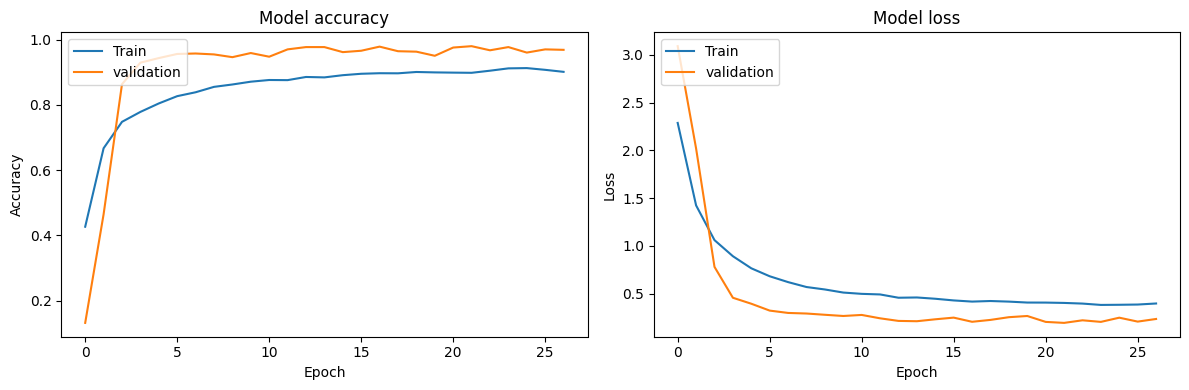

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


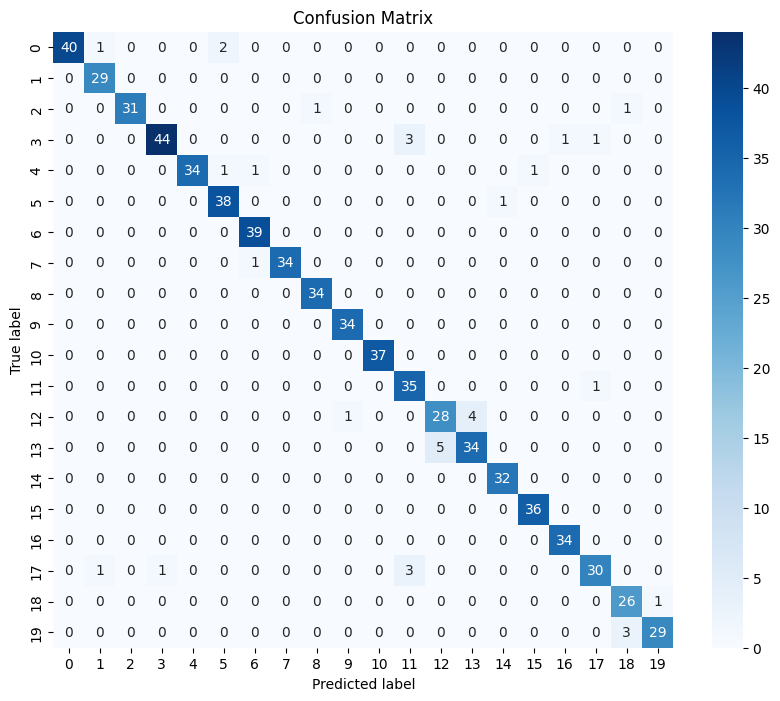

hidden accuracy: 0.9509116409537167


In [3]:

# Plot training & hiddenidation accuracy hiddenues
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

# Plot training & hiddenidation loss hiddenues
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_hidden)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_hidden, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# hidden accuracy calculation
hidden_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"hidden accuracy: {hidden_accuracy}")






In [4]:
for idx, layer in enumerate(model.layers):
    layer_name = layer.name
    input_shape = str(layer.input.shape)
    output_shape = str(layer.output.shape)
    weights = layer.get_weights()  # This returns a list of numpy arrays
    weights_shapes = [str(w.shape) for w in weights] if weights else "None"
    weights_shapes_str = ", ".join(weights_shapes) if isinstance(weights_shapes, list) else weights_shapes
    comments = "No weights" if not weights else f"Layer with {len(weights)} weight(s)"
    
    # Example to add specific comments based on layer type
    if 'conv' in layer_name.lower():
        comments = f"{weights_shapes[0][-1]} filters, {weights_shapes[0][0:2]} kernel size"
    elif 'dense' in layer_name.lower():
        comments = "Fully connected layer"
    elif 'flatten' in layer_name.lower():
        comments = "Flattens the input"
    elif 'pool' in layer_name.lower():
        comments = "Pooling layer"
    
    print(f"| {idx:<11} | {layer_name:<12} | {input_shape:<20} | {output_shape:<20} | {weights_shapes_str:<30} | {comments:<24} |")


| 0           | conv1d       | (None, 120, 1)       | (None, 118, 16)      | (3, 1, 16), (16,)              | ) filters, (3 kernel size |
| 1           | batch_normalization | (None, 118, 16)      | (None, 118, 16)      | (16,), (16,), (16,), (16,)     | Layer with 4 weight(s)   |
| 2           | max_pooling1d | (None, 118, 16)      | (None, 59, 16)       | None                           | Pooling layer            |
| 3           | flatten      | (None, 59, 16)       | (None, 944)          | None                           | Flattens the input       |
| 4           | dense        | (None, 944)          | (None, 16)           | (944, 16), (16,)               | Fully connected layer    |
| 5           | batch_normalization_1 | (None, 16)           | (None, 16)           | (16,), (16,), (16,), (16,)     | Layer with 4 weight(s)   |
| 6           | dropout      | (None, 16)           | (None, 16)           | None                           | No weights               |
| 7           | dense_1

In [5]:
    

# # save the one-hot encoding labels as json
# label_encoder_path = './model_dir/lab_encoder.json'
# label_encoder = label_encoder.classes_

# save the model
model_path = './model_dir/gesture_model.h5'
model.save(model_path)

In [1]:
# load the model

from tensorflow.keras.models import load_model

model_path = './model_dir/gesture_model.h5'

model = load_model(model_path)

# Evaluate the loaded model



2024-09-02 03:50:42.171396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 03:50:42.177389: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 03:50:42.237188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 03:50:42.286944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 03:50:42.345597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [4]:
# THIS FUNCTION IS USED TO GENERATE HLS CODE FOR A GIVEN KERAS MODEL WITH AXIS DATA STREAMING

import numpy as np

def generate_hls_code(model):
    # Create the header file content
    header_content = [
        '#include "ap_fixed.h"',
        '#include "ap_axi_sdata.h"',
        '//typedef ap_fixed<24, 12, AP_TRN, AP_SAT_SYM, 0> fixed_p;',
        'typedef float fixed_p;',
        'typedef hls::axis<float, 0, 0, 0> data_t;',
        'typedef hls::stream<data_t> mystream;'
    ]
    
    # Generate the HLS function definitions
    hls_functions = []
    gesture_model_body = []
    output_var_declarations = []
    
    # Track the index for naming variables
    from collections import defaultdict
    layer_vars = defaultdict(int)
    
    prev_output_var = "input"
    overall_input_size = model.layers[0].input.shape[1]  # Assume first layer's input shape for the gesture model
    
    for idx, layer in enumerate(model.layers):
        layer_type = layer.name.split('_')[0].lower()
        input_shape = layer.input.shape
        output_shape = layer.output.shape
        weights = layer.get_weights()

        print(f"Layer {idx}: {layer_type}")
        
        layer_idx = layer_vars[layer_type]
        layer_vars[layer_type] = layer_idx + 1
        
        if 'conv' in layer_type:
            kernel_size = weights[0].shape[0]
            num_filters = weights[0].shape[-1]
            input_size = input_shape[1]
            output_size = output_shape[1]
            channel_size = input_shape[2]

            # Generate Conv1D HLS code
            hls_functions.append(f"""
        void conv1d_{layer_idx}(fixed_p input[{input_size}][{channel_size}], fixed_p output[{output_size}][{num_filters}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_filters}; j++) // Loop over filters
                {{
                    fixed_p sum = 0;
                    for (int k = 0; k < {kernel_size}; k++) // Loop over the kernel size
                    {{
                        for (int c = 0; c < {channel_size}; c++) // Loop over input channels
                        {{
                            sum += input[i + k][c] * conv1d_{layer_idx}_weights[k][c][j];
                        }}
                    }}
                    output[i][j] = relu(sum + conv1d_{layer_idx}_biases[j]);
                }}
            }}
        }}
        """)
            # Add weight definitions to the header
            header_content.append(f"// Conv1D Layer {layer_idx} Weights")
            header_content.append(f"fixed_p conv1d_{layer_idx}_weights[{kernel_size}][{channel_size}][{num_filters}] = {{")
            for kernel in weights[0]:
                header_content.append(f"    {{{', '.join(map(str, kernel.flatten()))}}},")
            header_content.append("};")

            header_content.append(f"fixed_p conv1d_{layer_idx}_biases[{num_filters}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};\n")

            output_var = f"conv1d_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_filters}];")
            gesture_model_body.append(f"    conv1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'flatten' in layer_type:
            input_dim1 = input_shape[1]
            input_dim2 = input_shape[2]
            output_size = output_shape[1]

            # Generate Flatten HLS code
            hls_functions.append(f"""
void flatten_{layer_idx}(fixed_p input[{input_dim1}][{input_dim2}], fixed_p output[{output_size}])
{{
    #pragma HLS INLINE
    int idx = 0;
    for (int i = 0; i < {input_dim1}; i++)
    {{
        for (int j = 0; j < {input_dim2}; j++)
        {{
            output[idx++] = input[i][j];
        }}
    }}
}}
""")
            output_var = f"flatten_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    flatten_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'dense' in layer_type:
            input_size = input_shape[1]
            output_size = output_shape[1]
            
            activation = layer.activation.__name__.lower()

            if activation == 'softmax':
                # Generate Dense + Softmax HLS code
                hls_functions.append(f"""
        void dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    sum += input[j] * dense_{layer_idx}_weights[j][i];
                }}
                output[i] = sum + dense_{layer_idx}_biases[i]; // No ReLU before softmax
            }}

            fixed_p softmax_sum = 0;
            for (int i = 0; i < {output_size}; i++)
            {{
                softmax_sum += (fixed_p)exp(output[i]);
            }}
            for (int i = 0; i < {output_size}; i++)
            {{
                output[i] = (fixed_p)exp(output[i]) / softmax_sum;
            }}
        }}
        """)
            else:
                # Generate Dense HLS code with ReLU
                hls_functions.append(f"""
        void dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    sum += input[j] * dense_{layer_idx}_weights[j][i];
                }}
                output[i] = relu(sum + dense_{layer_idx}_biases[i]); // Apply ReLU
            }}
        }}
        """)

            # Add weight definitions to the header
            header_content.append(f"// Dense Layer {layer_idx} Weights")
            header_content.append(f"fixed_p dense_{layer_idx}_weights[{input_size}][{output_size}] = {{")
            for w in weights[0]:
                header_content.append(f"    {{{', '.join(map(str, w.flatten()))}}},")
            header_content.append("};")

            header_content.append(f"fixed_p dense_{layer_idx}_biases[{output_size}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};\n")

            output_var = f"dense_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    dense_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'batch' in layer_type:
            num_channels = input_shape[-1]  # Number of channels in the input/output

            # Check the shape of the previous output to determine the correct implementation
            if "conv1d_out" in prev_output_var:
                # Previous layer is a Conv1D layer
                hls_functions.append(f"""
        void batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}][{num_channels}], fixed_p output[{input_shape[1]}][{num_channels}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over time steps
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    output[i][j] = batch_norm_{layer_idx}_gamma[j] * ((input[i][j] - batch_norm_{layer_idx}_mean[j]) / (fixed_p)sqrt(batch_norm_{layer_idx}_variance[j] + (fixed_p)epsilon)) + batch_norm_{layer_idx}_beta[j];
                }}
            }}
        }}
        """)
            elif "dense_out" in prev_output_var:
                # Previous layer is a Dense layer
                hls_functions.append(f"""
        void batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}], fixed_p output[{input_shape[1]}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over neurons
            {{
                output[i] = batch_norm_{layer_idx}_gamma[i] * ((input[i] - batch_norm_{layer_idx}_mean[i]) / (fixed_p)sqrt(batch_norm_{layer_idx}_variance[i] + (fixed_p)epsilon)) + batch_norm_{layer_idx}_beta[i];
            }}
        }}
        """)

            # Add Batch Normalization parameters to the header
            header_content.append(f"// Batch Normalization Layer {layer_idx} Parameters")
            header_content.append(f"fixed_p batch_norm_{layer_idx}_gamma[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[0]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_beta[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_mean[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[2]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_variance[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[3]))}")
            header_content.append("};\n")

            output_var = f"batch_norm_out_{layer_idx}"
            if "conv1d_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}][{num_channels}];")
            elif "dense_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}];")
            
            gesture_model_body.append(f"    batch_normalization_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'max' in layer_type:
            pool_size = layer.pool_size[0]  # Size of the pooling window
            strides = layer.strides[0]  # Stride length
            num_channels = input_shape[2]

            # Calculate the output size
            input_length = input_shape[1]
            output_size = (input_length - pool_size) // strides + 1

            # Generate MaxPooling1D HLS code
            hls_functions.append(f"""
        void max_pooling1d_{layer_idx}(fixed_p input[{input_length}][{num_channels}], fixed_p output[{output_size}][{num_channels}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    fixed_p max_val = input[i * {strides}][j]; // Initialize max value
                    for (int k = 1; k < {pool_size}; k++) // Loop over pooling window
                    {{
                        int idx = i * {strides} + k;
                        if (idx < {input_length}) // Ensure within bounds
                        {{
                            max_val = (input[idx][j] > max_val) ? input[idx][j] : max_val;
                        }}
                    }}
                    output[i][j] = max_val;
                }}
            }}
        }}
        """)
            output_var = f"max_pool_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_channels}];")
            gesture_model_body.append(f"    max_pooling1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

    # Create the top-level function
    
    # remove the last layer output declaration
    output_var_declarations = output_var_declarations[:-1]
    
    last_gesture_model_body = gesture_model_body[-1]
    last_gesture_model_body = last_gesture_model_body.split(",")[0]
    last_gesture_model_body = last_gesture_model_body + ", output);"
    gesture_model_body[-1] = last_gesture_model_body
    
    gesture_model_function = f"""
void gesture_model(mystream &input_stream, mystream &output_stream)
{{
#pragma HLS INTERFACE mode = axis port = input_stream
#pragma HLS INTERFACE mode = axis port = output_stream
#pragma HLS INTERFACE mode = s_axilite port = return

    data_t in, out;
    fixed_p input[{overall_input_size}][1];
    fixed_p output[{output_size}];

{chr(10).join(output_var_declarations)}

    // Read data from the input AXI stream
    for (int i = 0; i < {overall_input_size}; i++) {{
        for (int j = 0; j < 1; j++) {{
            input_stream.read(in);
            input[i][j] = in.data;
        }}
    }}

    // Perform the neural network operations
#pragma HLS DATAFLOW
{chr(10).join(gesture_model_body)}

// Write the output to the output AXI stream
    out.keep = -1;
    out.last = 0;

    for (uint i = 0; i < {output_size}; i++)
    {{
        out.data = output[i];
        out.last = (i == {output_size - 1}) ? 1 : 0;
        output_stream.write(out);
    }}
}}
"""

    hls_functions.append(gesture_model_function)

    return "\n".join(header_content), "\n".join(hls_functions)

# Example usage
header, hls_code = generate_hls_code(model)

with open("core.h", "w") as header_file:
    header_file.write(header)

with open("core.cpp", "w") as hls_file:
    hls_file.write("#include <iostream>\n")
    hls_file.write("#include <cmath>\n")
    hls_file.write("#include <hls_stream.h>\n")
    hls_file.write("#include \"core.h\"\n")
    
    hls_file.write(
    """
// declare epsilon for Batch Normalization
#define epsilon 0.001

// Custom abs function for fixed_p type
fixed_p custom_abs(fixed_p x)
{
    #pragma HLS INLINE
    return (x < fixed_p(0)) ? fixed_p(-x) : x;
}

// ReLU function
fixed_p relu(fixed_p x)
{
    #pragma HLS INLINE
    return x > fixed_p(0) ? x : fixed_p(0);
}
    """
    )
    hls_file.write(hls_code)



Layer 0: conv1d
Layer 1: batch
Layer 2: max
Layer 3: flatten
Layer 4: dense
Layer 5: batch
Layer 6: dropout
Layer 7: dense


In [2]:
import numpy as np

# THIS FUNCTION IS USED TO GENERATE HLS CODE FOR A GIVEN KERAS MODEL WITHOUT  AXIS DATA STREAMING

def generate_hls_code(model):
    # Create the header file content
    header_content = [
        "typedef float fixed_p;",
        ""
    ]
    
    # Generate the HLS function definitions
    hls_functions = []
    gesture_model_body = []
    output_var_declarations = []
    
    # Track the index for naming variables
    from collections import defaultdict
    layer_vars = defaultdict(int)
    
    prev_output_var = "input"
    overall_input_size = model.layers[0].input.shape[1]  # Assume first layer's input shape for the gesture model
    
    for idx, layer in enumerate(model.layers):
        layer_type = layer.name.split('_')[0].lower()
        input_shape = layer.input.shape
        output_shape = layer.output.shape
        weights = layer.get_weights()

        print(f"Layer {idx}: {layer_type}")
        
        layer_idx = layer_vars[layer_type]
        layer_vars[layer_type] = layer_idx + 1
        
        if 'conv' in layer_type:
            kernel_size = weights[0].shape[0]
            num_filters = weights[0].shape[-1]
            input_size = input_shape[1]
            output_size = output_shape[1]
            channel_size = input_shape[2]

            # Generate Conv1D HLS code
            hls_functions.append(f"""
        void conv1d_{layer_idx}(fixed_p input[{input_size}][{channel_size}], fixed_p output[{output_size}][{num_filters}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_filters}; j++) // Loop over filters
                {{
                    fixed_p sum = 0;
                    for (int k = 0; k < {kernel_size}; k++) // Loop over the kernel size
                    {{
                        for (int c = 0; c < {channel_size}; c++) // Loop over input channels
                        {{
                            sum += input[i + k][c] * conv1d_{layer_idx}_weights[k][c][j];
                        }}
                    }}
                    output[i][j] = relu(sum + conv1d_{layer_idx}_biases[j]);
                }}
            }}
        }}
        """)
            # Add weight definitions to the header
            header_content.append(f"// Conv1D Layer {layer_idx} Weights")
            header_content.append(f"fixed_p conv1d_{layer_idx}_weights[{kernel_size}][{channel_size}][{num_filters}] = {{")
            for kernel in weights[0]:
                header_content.append(f"    {{{', '.join(map(str, kernel.flatten()))}}},")
            header_content.append("};")

            header_content.append(f"fixed_p conv1d_{layer_idx}_biases[{num_filters}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};\n")

            output_var = f"conv1d_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_filters}];")
            gesture_model_body.append(f"    conv1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'flatten' in layer_type:
            input_dim1 = input_shape[1]
            input_dim2 = input_shape[2]
            output_size = output_shape[1]

            # Generate Flatten HLS code
            hls_functions.append(f"""
void flatten_{layer_idx}(fixed_p input[{input_dim1}][{input_dim2}], fixed_p output[{output_size}])
{{
    int idx = 0;
    for (int i = 0; i < {input_dim1}; i++)
    {{
        for (int j = 0; j < {input_dim2}; j++)
        {{
            output[idx++] = input[i][j];
        }}
    }}
}}
""")
            output_var = f"flatten_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    flatten_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'dense' in layer_type:
            input_size = input_shape[1]
            output_size = output_shape[1]
            
            activation = layer.activation.__name__.lower()

            if activation == 'softmax':
                # Generate Dense + Softmax HLS code
                hls_functions.append(f"""
        void dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    sum += input[j] * dense_{layer_idx}_weights[j][i];
                }}
                output[i] = sum + dense_{layer_idx}_biases[i]; // No ReLU before softmax
            }}

            fixed_p softmax_sum = 0;
            for (int i = 0; i < {output_size}; i++)
            {{
                softmax_sum += (fixed_p)exp(output[i]);
            }}
            for (int i = 0; i < {output_size}; i++)
            {{
                output[i] = (fixed_p)exp(output[i]) / softmax_sum;
            }}
        }}
        """)
            else:
                # Generate Dense HLS code with ReLU
                hls_functions.append(f"""
        void dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    sum += input[j] * dense_{layer_idx}_weights[j][i];
                }}
                output[i] = relu(sum + dense_{layer_idx}_biases[i]); // Apply ReLU
            }}
        }}
        """)

            # Add weight definitions to the header
            header_content.append(f"// Dense Layer {layer_idx} Weights")
            header_content.append(f"fixed_p dense_{layer_idx}_weights[{input_size}][{output_size}] = {{")
            for w in weights[0]:
                header_content.append(f"    {{{', '.join(map(str, w.flatten()))}}},")
            header_content.append("};")

            header_content.append(f"fixed_p dense_{layer_idx}_biases[{output_size}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};\n")

            output_var = f"dense_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    dense_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'batch' in layer_type:
            num_channels = input_shape[-1]  # Number of channels in the input/output

            # Check the shape of the previous output to determine the correct implementation
            if "conv1d_out" in prev_output_var:
                # Previous layer is a Conv1D layer
                hls_functions.append(f"""
        void batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}][{num_channels}], fixed_p output[{input_shape[1]}][{num_channels}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over time steps
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    output[i][j] = batch_norm_{layer_idx}_gamma[j] * ((input[i][j] - batch_norm_{layer_idx}_mean[j]) / (fixed_p)sqrt(batch_norm_{layer_idx}_variance[j] + (fixed_p)epsilon)) + batch_norm_{layer_idx}_beta[j];
                }}
            }}
        }}
        """)
            elif "dense_out" in prev_output_var:
                # Previous layer is a Dense layer
                hls_functions.append(f"""
        void batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}], fixed_p output[{input_shape[1]}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over neurons
            {{
                output[i] = batch_norm_{layer_idx}_gamma[i] * ((input[i] - batch_norm_{layer_idx}_mean[i]) / (fixed_p)sqrt(batch_norm_{layer_idx}_variance[i] + (fixed_p)epsilon)) + batch_norm_{layer_idx}_beta[i];
            }}
        }}
        """)

            # Add Batch Normalization parameters to the header
            header_content.append(f"// Batch Normalization Layer {layer_idx} Parameters")
            header_content.append(f"fixed_p batch_norm_{layer_idx}_gamma[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[0]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_beta[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[1]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_mean[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[2]))}")
            header_content.append("};")

            header_content.append(f"fixed_p batch_norm_{layer_idx}_variance[{num_channels}] = {{")
            header_content.append(f"    {', '.join(map(str, weights[3]))}")
            header_content.append("};\n")

            output_var = f"batch_norm_out_{layer_idx}"
            if "conv1d_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}][{num_channels}];")
            elif "dense_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}];")
            
            gesture_model_body.append(f"    batch_normalization_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'max' in layer_type:
            pool_size = layer.pool_size[0]  # Size of the pooling window
            strides = layer.strides[0]  # Stride length
            num_channels = input_shape[2]

            # Calculate the output size
            input_length = input_shape[1]
            output_size = (input_length - pool_size) // strides + 1

            # Generate MaxPooling1D HLS code
            hls_functions.append(f"""
        void max_pooling1d_{layer_idx}(fixed_p input[{input_length}][{num_channels}], fixed_p output[{output_size}][{num_channels}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    fixed_p max_val = input[i * {strides}][j]; // Initialize max value
                    for (int k = 1; k < {pool_size}; k++) // Loop over pooling window
                    {{
                        int idx = i * {strides} + k;
                        if (idx < {input_length}) // Ensure within bounds
                        {{
                            max_val = (input[idx][j] > max_val) ? input[idx][j] : max_val;
                        }}
                    }}
                    output[i][j] = max_val;
                }}
            }}
        }}
        """)
            output_var = f"max_pool_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_channels}];")
            gesture_model_body.append(f"    max_pooling1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

    # Create the top-level function
    
    # remove the last layer output declaration
    output_var_declarations = output_var_declarations[:-1]
    
    last_gesture_model_body = gesture_model_body[-1]
    last_gesture_model_body = last_gesture_model_body.split(",")[0]
    last_gesture_model_body = last_gesture_model_body + ", output);"
    gesture_model_body[-1] = last_gesture_model_body
    
    gesture_model_function = f"""
void gesture_model(fixed_p input[{overall_input_size}][1], fixed_p output[{output_size}])
{{
{chr(10).join(output_var_declarations)}
{chr(10).join(gesture_model_body)}
}}
"""

    hls_functions.append(gesture_model_function)

    return "\n".join(header_content), "\n".join(hls_functions)

# Example usage
header, hls_code = generate_hls_code(model)

with open("core.h", "w") as header_file:
    header_file.write(header)

with open("core.cpp", "w") as hls_file:
    hls_file.write("#include <iostream>\n")
    hls_file.write("#include <cmath>\n")
    hls_file.write("#include \"core.h\"\n")
    
    hls_file.write(
    """
// declare epsilon for Batch Normalization
#define epsilon 0.001

// Custom abs function for fixed_p type
fixed_p custom_abs(fixed_p x)
{
    return (x < fixed_p(0)) ? fixed_p(-x) : x;
}

// ReLU function
fixed_p relu(fixed_p x)
{
    return x > fixed_p(0) ? x : fixed_p(0);
}
    """
    )
    hls_file.write(hls_code)


Layer 0: conv1d
Layer 1: batch
Layer 2: max
Layer 3: flatten
Layer 4: dense
Layer 5: batch
Layer 6: dropout
Layer 7: dense


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import random

# Load the processed hidden data
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Prepare the input data
X_hidden = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                     for _, row in hidden_data.iterrows()], dtype=np.float32)

# Prepare the labels
label_encoder = LabelEncoder()
y_hidden = label_encoder.fit_transform(hidden_data['gesture'])
y_hidden = pd.get_dummies(y_hidden).values

# Reshape input data to match the input shape expected by the 1D CNN
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

model = load_model('./model_dir/gesture_model.h5')

test_inputs = []
expected_outputs = []
expected_classes = []

for i in range(10):
    random_index = random.randint(0, len(X_hidden) - 1)
    random_input = X_hidden[random_index:random_index + 1]

    # Generate the input values
    input_values = ', '.join(f'{{{v}}}' for v in random_input.flatten())
    test_inputs.append(input_values)

    # Get the model prediction for the random input
    prediction = model.predict(random_input)
    output_values = ', '.join(map(str, prediction.flatten()))
    expected_outputs.append(output_values)

    # Get the expected class (index of the maximum value in prediction)
    expected_class = np.argmax(prediction)
    expected_classes.append(str(expected_class))

# Save the arrays to a file
with open("test_arrays.h", "w") as file:
    # Write the test_input array
    file.write("fixed_p test_input[10][120][1] = {\n")
    for i, vals in enumerate(test_inputs):
        file.write(f"    {{{vals}}}")
        if i < len(test_inputs) - 1:
            file.write(",\n")
    file.write("\n};\n\n")

    # Write the expected_output array
    file.write("fixed_p expected_output[10][20] = {\n")
    for i, vals in enumerate(expected_outputs):
        file.write(f"    {{{vals}}}")
        if i < len(expected_outputs) - 1:
            file.write(",\n")
    file.write("\n};\n\n")

    # Write the expected_class array
    file.write("int expected_class[10] = {\n")
    for i, cls in enumerate(expected_classes):
        file.write(f"    {cls}")
        if i < len(expected_classes) - 1:
            file.write(",\n")
    file.write("\n};\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
